In [9]:
import pandas as pd
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
from cv2 import aruco

In [2]:
calibration_images_path = os.path.join(os.getcwd(), "calibration", "img*.png")
images = glob.glob(calibration_images_path)

In [3]:
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_16h5)
detectorParams = aruco.DetectorParameters()
detectorParams.cornerRefinementMethod = aruco.CORNER_REFINE_CONTOUR
detector = aruco.ArucoDetector(aruco_dict, detectorParams)

In [ ]:
marker_size = 0.168
marker_gap = 0.007

step_size = marker_size + marker_gap


top_left = [0, 0, 0]

aruco_marker = [
    [top_left[0], top_left[1] + marker_size, 0],    
    top_left,
    [top_left[0] + marker_size, top_left[1], 0],         
    [top_left[0] + marker_size, top_left[1] + marker_size, 0],   
]


aruco_marker = np.array(aruco_marker, dtype=np.float32)


aruco_board = []
for x in range(3):
    for y in range(2):    
        top_left = [x * step_size, y * step_size, 0]
        
        corners_3d = [
            [top_left[0], top_left[1] + marker_size, 0],
            top_left,
            [top_left[0] + marker_size, top_left[1], 0],         
            [top_left[0] + marker_size, top_left[1] + marker_size, 0],        
        ]
        
        aruco_board.extend(corners_3d)

aruco_board = np.array(aruco_board, dtype=np.float32)


## Task 1

### One Marker

In [5]:
objpoints = []
imgpoints = []

for image_path in images:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    corners, ids, _ = detector.detectMarkers(gray)
    
    if ids is not None and len(ids) > 0:
        for marker in corners:
            points = marker.reshape(-1, 1, 2)
            points = points.astype('float32')
            imgpoints.append(points)
            objpoints.append(aruco_marker)

# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
#     objpoints, imgpoints, gray.shape[::-1], None, None
# )

# for img in images:
#     size = (img.shape[1], img.shape[0])

#     alpha = 0.5
#     rect_camera_matrix = cv2.getOptimalNewCameraMatrix(mtx, dist, size, alpha)[0]
#     map1, map2 = cv2.initUndistortRectifyMap(mtx, dist, np.eye(3), rect_camera_matrix, size, cv2.CV_32FC1)

#     rect_img0 = cv2.remap(img, map1, map2, cv2.INTER_LINEAR)

#     cv2.imshow(cv2.hconcat([img, rect_img0]))
#     cv2.waitKey(500)
#     cv2.destroyAllWindows()

### Big Board

In [38]:
objpoints = []
imgpoints = []

for image_path in images:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    corners, ids, _ = detector.detectMarkers(gray)
    
    if ids is not None and len(ids) > 0:
        points = np.array([])

        for marker in corners:
            points = np.append(points, marker)

        points = points.reshape(-1, 1, 2)
        points = points.astype('float32')
        imgpoints.append(points)
        objpoints.append(aruco_board)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

In [39]:
# import matplotlib.pyplot as plt
# # plt.figure(figsize=(10, 8))
# plt.scatter(points[:, 0, 0], points[:, 0,  1], color='blue', label='Points')
# for idx, point in enumerate(points):
#     x, y = point[0][0], point[0][1]
#     plt.text(x, y, str(idx), fontsize=9, ha='right', color='red')

# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Scatter Plot of Points with Index Labels')
# plt.grid(True)
# plt.legend()
# plt.show()

# import matplotlib.pyplot as plt
# # plt.figure(figsize=(10, 8))
# plt.scatter(aruco_board[:, 0], aruco_board[:,  1], color='blue', label='Points')
# for idx, point in enumerate(aruco_board):
#     x, y = point[0], point[1]
#     plt.text(x, y, str(idx), fontsize=9, ha='right', color='red')

# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Scatter Plot of Points with Index Labels')
# plt.grid(True)
# plt.legend()
# plt.show()

In [40]:
for img in images:
    img = cv2.imread(img)
    size = (img.shape[1], img.shape[0])

    alpha = 0.5
    rect_camera_matrix = cv2.getOptimalNewCameraMatrix(mtx, dist, size, alpha)[0]
    map1, map2 = cv2.initUndistortRectifyMap(mtx, dist, np.eye(3), rect_camera_matrix, size, cv2.CV_32FC1)

    rect_img0 = cv2.remap(img, map1, map2, cv2.INTER_LINEAR)

    cv2.imshow('Obrazki', cv2.hconcat([img, rect_img0]))
    cv2.waitKey(1000)
    cv2.destroyAllWindows()

## Task 2

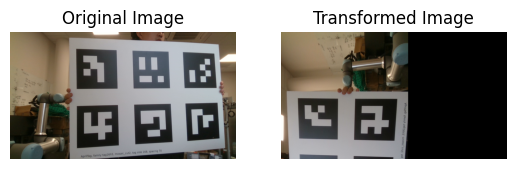

In [ ]:


def apply_projective_transform(image, H, output_size):
    """
    Apply projective transformation to an image using a given homography matrix.

    Parameters:
    - image: Input image as a numpy array.
    - H: 3x3 projective transformation matrix (homography).
    - output_size: Tuple (width, height) for the output image size.

    Returns:
    - Transformed image as a numpy array.
    """
    H_inv = np.linalg.inv(H)
    
    transformed_image = np.zeros((output_size[1], output_size[0], 3), dtype=image.dtype)
    
    for y in range(output_size[1]):
        for x in range(output_size[0]):
            dest_coord = np.array([x, y, 1])
            
            source_coord = H_inv @ dest_coord
            source_x, source_y = source_coord[:2] / source_coord[2]
            
            source_x, source_y = int(round(source_x)), int(round(source_y))
            
            if 0 <= source_x < image.shape[1] and 0 <= source_y < image.shape[0]:
                transformed_image[y, x] = image[source_y, source_x]
    
    return transformed_image

image = cv2.imread(images[0])

H = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]
])

output_size = (image.shape[1], image.shape[0])

transformed_image = apply_projective_transform(image, H, output_size)

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Transformed Image")
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()


## Task 3

In [ ]:
import numpy as np

def compute_homography(points_src, points_dst):
    """
    Computes the homography matrix H such that points_dst ≈ H * points_src.
    
    Parameters:
    - points_src: Nx2 array of source points.
    - points_dst: Nx2 array of destination points.
    
    Returns:
    - H: 3x3 homography matrix that maps points_src to points_dst.
    """
    num_points = points_src.shape[0]
    assert num_points == points_dst.shape[0] and num_points >= 4, "At least 4 points are required."
    
    A = []
    for i in range(num_points):
        x, y = points_src[i]
        u, v = points_dst[i]
        
        A.append([-x, -y, -1, 0, 0, 0, u * x, u * y, u])
        A.append([0, 0, 0, -x, -y, -1, v * x, v * y, v])
    
    A = np.array(A)
    
    _, _, V = np.linalg.svd(A)
    
    H = V[-1, :].reshape(3, 3)
    
    return H / H[2, 2]
def test_homography():
    for _ in range(10):
        H_true = np.random.rand(3, 3)
        H_true[2, 2] = 1
        
        num_points = 8
        points_src = np.random.rand(num_points, 2) * 100
        points_src_homogeneous = np.hstack([points_src, np.ones((num_points, 1))])
        
        points_dst_homogeneous = (H_true @ points_src_homogeneous.T).T
        points_dst = points_dst_homogeneous[:, :2] / points_dst_homogeneous[:, [2]]
        
        H_estimated = compute_homography(points_src, points_dst)
        
        H_true /= H_true[2, 2]
        H_estimated /= H_estimated[2, 2]
        
        assert np.allclose(H_true, H_estimated, atol=1e-6), "Homography estimation failed!"
    
    print("All tests passed!")

test_homography()


All tests passed!


## Task 4

In [30]:
import cv2

# Global variables for zoom and image position
zoom_factor = 1.0
img_position = (0, 0)  # Start at the top-left corner

# Function to handle mouse events
def click_event(event, x, y, flags, params):
    global zoom_factor, img_position
    
    if event == cv2.EVENT_LBUTTONDOWN:
        # Adjust x and y coordinates according to zoom and pan
        zoomed_x = int((x + img_position[0]) / zoom_factor)
        zoomed_y = int((y + img_position[1]) / zoom_factor)
        print(f'Clicked Coordinates: ({zoomed_x},{zoomed_y})')

        # Draw a small circle on the clicked point
        cv2.circle(displayed_img, (x, y), 3, (0, 255, 255), -1)
        cv2.imshow('Point Coordinates', displayed_img)

def update_displayed_image():
    """Update the displayed image according to the current zoom and position."""
    global displayed_img, img_position
    h, w = img.shape[:2]
    new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
    
    # Resize image according to the zoom factor
    resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # Create the region of interest (ROI) to display within the window boundaries
    x, y = img_position
    displayed_img = resized_img[y:y + h, x:x + w]

# Function to handle keyboard events for zooming
def zoom_in():
    global zoom_factor
    zoom_factor = min(zoom_factor + 0.1, 3.0)  # Max zoom limit at 3.0x
    update_displayed_image()

def zoom_out():
    global zoom_factor
    zoom_factor = max(zoom_factor - 0.1, 0.5)  # Min zoom limit at 0.5x
    update_displayed_image()

# Load the image
img = cv2.imread('stitching/img8.png')
displayed_img = img.copy()  # This will be the displayed image in the window

# Set up the window and mouse callback
cv2.namedWindow('Point Coordinates')
cv2.setMouseCallback('Point Coordinates', click_event)

while True:
    cv2.imshow('Point Coordinates', displayed_img)
    k = cv2.waitKey(1) & 0xFF
    
    if k == 10:  # Enter key to exit
        break
    elif k == ord('+'):  # '+' key to zoom in
        zoom_in()
    elif k == ord('-'):  # '-' key to zoom out
        zoom_out()

cv2.destroyAllWindows()


Clicked Coordinates: (801,278)
Clicked Coordinates: (824,304)
Clicked Coordinates: (849,289)
Clicked Coordinates: (827,262)
Clicked Coordinates: (855,520)
Clicked Coordinates: (899,522)
Clicked Coordinates: (896,483)
Clicked Coordinates: (856,480)


KeyboardInterrupt: 

In [31]:
import cv2

# Global variables for zoom and image position
zoom_factor = 1.0
img_position = (0, 0)  # Start at the top-left corner

# Function to handle mouse events
def click_event(event, x, y, flags, params):
    global zoom_factor, img_position
    
    if event == cv2.EVENT_LBUTTONDOWN:
        # Adjust x and y coordinates according to zoom and pan
        zoomed_x = int((x + img_position[0]) / zoom_factor)
        zoomed_y = int((y + img_position[1]) / zoom_factor)
        print(f'Clicked Coordinates: ({zoomed_x},{zoomed_y})')

        # Draw a small circle on the clicked point
        cv2.circle(displayed_img, (x, y), 3, (0, 255, 255), -1)
        cv2.imshow('Point Coordinates', displayed_img)

def update_displayed_image():
    """Update the displayed image according to the current zoom and position."""
    global displayed_img, img_position
    h, w = img.shape[:2]
    new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
    
    # Resize image according to the zoom factor
    resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # Create the region of interest (ROI) to display within the window boundaries
    x, y = img_position
    displayed_img = resized_img[y:y + h, x:x + w]

# Function to handle keyboard events for zooming
def zoom_in():
    global zoom_factor
    zoom_factor = min(zoom_factor + 0.1, 3.0)  # Max zoom limit at 3.0x
    update_displayed_image()

def zoom_out():
    global zoom_factor
    zoom_factor = max(zoom_factor - 0.1, 0.5)  # Min zoom limit at 0.5x
    update_displayed_image()

# Load the image
img = cv2.imread('stitching/img9.png')
displayed_img = img.copy()  # This will be the displayed image in the window

# Set up the window and mouse callback
cv2.namedWindow('Point Coordinates')
cv2.setMouseCallback('Point Coordinates', click_event)

while True:
    cv2.imshow('Point Coordinates', displayed_img)
    k = cv2.waitKey(1) & 0xFF
    
    if k == 10:  # Enter key to exit
        break
    elif k == ord('+'):  # '+' key to zoom in
        zoom_in()
    elif k == ord('-'):  # '-' key to zoom out
        zoom_out()

cv2.destroyAllWindows()


Clicked Coordinates: (883,275)
Clicked Coordinates: (903,303)
Clicked Coordinates: (932,288)
Clicked Coordinates: (907,258)
Clicked Coordinates: (940,521)
Clicked Coordinates: (987,522)
Clicked Coordinates: (984,484)
Clicked Coordinates: (939,483)


KeyboardInterrupt: 

In [33]:
img8_points = np.array([
    [801,278], 
    [824,304], 
    [849,289], 
    [827,262], 
    [855,520], 
    [899,522], 
    [896,483],
    [856,480]
])

img9_points = np.array([
    [883,275], 
    [903,303], 
    [932,288], 
    [907,258], 
    [940,521], 
    [987,522], 
    [984,484],
    [939,483]
])

In [35]:
H = compute_homography(img8_points, img9_points)

H

array([[-1.67177429e+00,  1.72677790e-01,  1.15312626e+03],
       [-6.35394891e-01, -1.36812336e-01,  5.08130643e+02],
       [-1.51056279e-03,  1.80277210e-04,  1.00000000e+00]])

## Task 5

In [42]:
img8 = cv2.imread("stitching/img8.png")
img9 = cv2.imread("stitching/img9.png")

height, width = img9.shape[:2]

warped_img8 = cv2.warpPerspective(img8, H, (width, height))

## Task 6